In [1]:
import os
import numpy as np
import glob
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
sns.set()

import sys; sys.path.insert(0, "../utils/")
from data_utils import get_data_location, get_clinical_df, get_bluepoints_df, get_manual_severity_scores
from ml_pipeline import ModelEvaluation, highlight_max

DATA_PATH = get_data_location()

In [2]:
DIAGRAMS_PATH = os.path.join(DATA_PATH,"cropped_videos_segmented/persistence_diagrams")

# List all files & directories
diagrams_files = os.listdir(DIAGRAMS_PATH)

# keep only files that end with .npy
diagrams_files = [x for x in diagrams_files if x.endswith(".npy")]

len(diagrams_files)

369

In [3]:
# Load the first file
diagrams = np.load(os.path.join(DIAGRAMS_PATH, diagrams_files[0]), allow_pickle=True)
diagrams.shape

(4, 9439, 3)

In [4]:
from gtda.plotting import plot_diagram
# plot_diagram(diagrams[0])

In [5]:
from gtda.diagrams import PersistenceEntropy

persistence_entropy = PersistenceEntropy()

# calculate topological feature matrix
X_basic = persistence_entropy.fit_transform(diagrams)

# expect shape - (n_point_clouds, n_homology_dims)
print(X_basic.shape)

# flatten the matrix to get one feature vector per video
X_basic = X_basic.flatten()
X_basic.shape

(4, 3)


(12,)

In [ ]:
import pandas as pd

# Create a dataframe from digrams_files
df = pd.DataFrame(diagrams_files, columns=["file_name"])

# Split the file name to get the patient id
df["Patient ID"] = df["file_name"].apply(lambda x: x.split("_")[1])
# Split the file name to get the video name
df["video_name"] = df["file_name"].apply(lambda x: x.split("_")[2] + "_" + x.split("_")[3])
# Load the diagrams into the dataframe
df["diagrams"] = df["file_name"].apply(lambda x: np.load(os.path.join(DIAGRAMS_PATH, x), allow_pickle=True))

df.head()

In [ ]:
clinical_data = get_clinical_df()

clinical_data = clinical_data[["Video ID", "clin_diagn#COVID19_pneumonia"]]
clinical_data.columns = ["Patient ID", "COVID19"]
df = pd.merge(df, clinical_data, on="Patient ID", how="left")

bp = get_bluepoints_df()
df = pd.merge(df, bp[["Bluepoint", "video_name"]], on="video_name", how="left")

df.head(1)

In [8]:
def featurize_diagram(diagram, representation):
    """Featurize diagrams with a given representation.
    
    Parameters
    ----------
    diagram : ndarray
        A persistence diagram in the gtda format.
    representation : object
        A representation object from gtda.diagrams.
        
    Returns
    -------
    X : ndarray
        A feature vector.
    """
    return representation.fit_transform(diagram).flatten()


In [ ]:
# Import different featurizers
from gtda.diagrams import PersistenceEntropy
from gtda.diagrams import Amplitude
from gtda.diagrams import BettiCurve
from gtda.diagrams import PersistenceImage
from gtda.diagrams import NumberOfPoints

# Store all featurizer in a dict with name as key
featurizers = {"Persistence Entropy" : PersistenceEntropy(),
                "Number of Points" : NumberOfPoints(),
                "Wasserstein Amplitude" : Amplitude(metric='wasserstein'),
                "Bottleneck Amplitude" : Amplitude(metric='bottleneck'),
                "Landscape Amplitude" : Amplitude(metric='landscape'),
                "Betti Curves" : BettiCurve(n_bins=20),
                "Persistence Image" : PersistenceImage(n_bins=10, n_jobs=-1), 
                
                }

# Apply the different featurizers to the diagrams and add them to the dataframe in separate columns
for name, featurizer in featurizers.items():
    print(f"Calculating {name}")
    df[name] = df["diagrams"].apply(lambda x: featurize_diagram(x, featurizer))
df.head(1)

## Train models

In [27]:
Classifier = ModelEvaluation("classification")

In [28]:
featurizer_models = pd.DataFrame()
featurizer_models_all = pd.DataFrame()
featurizer_models_std = pd.DataFrame()
for name, featurizer in featurizers.items():
    print(f"Training model for {name}...")
    X = np.stack(df[name].values)
    y = df["COVID19"].values
    groups = df["Patient ID"].values
    
    scores, scores_mean, scores_std = Classifier.train_models(X, y, groups=groups, plot=False, return_std = True)
    scores = pd.concat([scores], keys=[name], names=['Featurizer'])
    scores_mean = pd.concat([scores_mean], keys=[name], names=['Featurizer'])
    scores_std = pd.concat([scores_std], keys=[name], names=['Featurizer'])
    
    featurizer_models_all = pd.concat([featurizer_models_all, scores])
    featurizer_models = pd.concat([featurizer_models, scores_mean])
    featurizer_models_std = pd.concat([featurizer_models_std, scores_std])
    
featurizer_models.groupby("Featurizer").mean().sort_values(by=["test_accuracy", "test_f1"], ascending=False).style.apply(highlight_max).format("{:.2f}")

Training model for Persistence Entropy...
Training model for Number of Points...
Training model for Wasserstein Amplitude...
Training model for Bottleneck Amplitude...
Training model for Landscape Amplitude...
Training model for Betti Curves...
Training model for Persistence Image...


/scratch_net/gnarf/mrichte/conda_envs/DL4LUS/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:444: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/scratch_net/gnarf/mrichte/conda_envs/DL4LUS/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:444: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/st

,test_accuracy,test_sensitivity,test_specificity,test_f1
Featurizer,,,,
Number of Points,0.68,0.78,0.63,0.72
Persistence Entropy,0.64,0.74,0.59,0.68
Betti Curves,0.62,0.69,0.61,0.65
Persistence Image,0.62,0.68,0.60,0.65
Bottleneck Amplitude,0.60,0.70,0.58,0.64
Wasserstein Amplitude,0.60,0.71,0.56,0.65
Landscape Amplitude,0.59,0.65,0.61,0.62


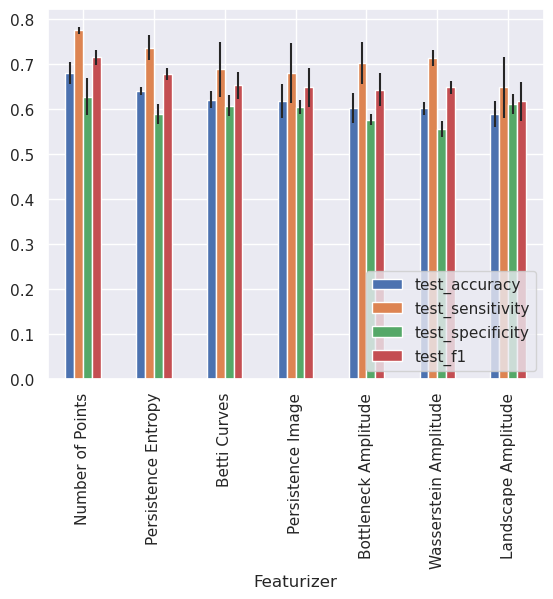

In [29]:
featurizer_models.groupby("Featurizer").mean().sort_values(by=["test_accuracy", "test_f1"], ascending=False).plot.bar(yerr=featurizer_models.groupby("Featurizer").std())
plt.legend(loc='lower right')

,test_accuracy,test_sensitivity,test_specificity,test_f1
Number of Points (SVM),0.70,0.78,0.65,0.73
Persistence Image (RF),0.66,0.76,0.62,0.70
Persistence Entropy (RF),0.65,0.77,0.56,0.69
Betti Curves (RF),0.64,0.76,0.58,0.69
Bottleneck Amplitude (RF),0.64,0.76,0.59,0.68
Landscape Amplitude (RF),0.62,0.73,0.59,0.67
Wasserstein Amplitude (RF),0.62,0.73,0.58,0.67


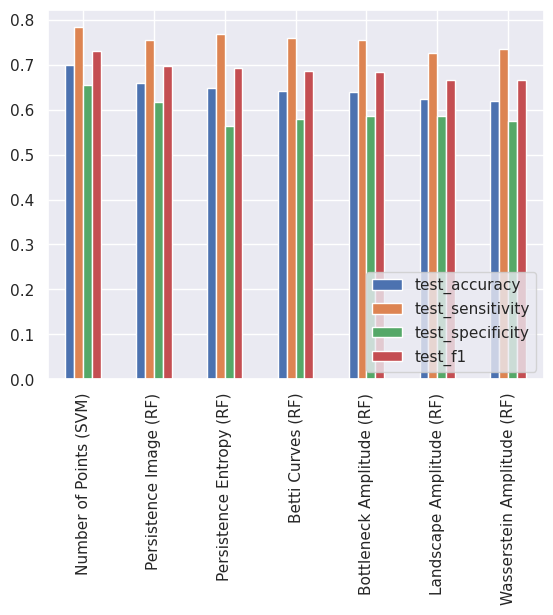

In [30]:
grouped = featurizer_models.groupby("Featurizer")
max_index = grouped["test_accuracy"].idxmax()
best_models = featurizer_models.loc[max_index].sort_values("test_accuracy", ascending=False)
best_models.index = best_models.reset_index().Featurizer + " (" + best_models.reset_index().model + ")"

best_models_std = featurizer_models_std.loc[max_index]
best_models_std.index = best_models_std.reset_index().Featurizer + " (" + best_models_std.reset_index().model + ")"
best_models_std = best_models_std.loc[best_models.index]

best_models.plot.bar()
plt.legend(loc='lower right')

best_models.style.apply(highlight_max).format("{:.2f}")

In [31]:
# Make latex
latex = best_models.applymap(lambda x: f"{x:.2f}") + " $_{\pm " + best_models_std.applymap(lambda x: f"{x:.2f}") + "}$"
# Drop all rows containint "Amplitude"
latex = latex[~latex.index.str.contains("Amplitude")]
print(latex.to_latex(escape=False))

\begin{tabular}{lllll}
\toprule
{} &       test_accuracy &    test_sensitivity &    test_specificity &             test_f1 \\
\midrule
Number of Points (SVM)   &  0.70 $_{\pm 0.03}$ &  0.78 $_{\pm 0.09}$ &  0.65 $_{\pm 0.17}$ &  0.73 $_{\pm 0.05}$ \\
Persistence Image (RF)   &  0.66 $_{\pm 0.02}$ &  0.76 $_{\pm 0.12}$ &  0.62 $_{\pm 0.19}$ &  0.70 $_{\pm 0.04}$ \\
Persistence Entropy (RF) &  0.65 $_{\pm 0.02}$ &  0.77 $_{\pm 0.09}$ &  0.56 $_{\pm 0.17}$ &  0.69 $_{\pm 0.05}$ \\
Betti Curves (RF)        &  0.64 $_{\pm 0.04}$ &  0.76 $_{\pm 0.09}$ &  0.58 $_{\pm 0.26}$ &  0.69 $_{\pm 0.07}$ \\
\bottomrule
\end{tabular}



# Patient Level


In [32]:
# Aggregate feature vectors across each Patient using the mean
patient_level_df = df.groupby("Patient ID")[list(featurizers.keys())].mean().reset_index()
# Add back Covid variable
patient_level_df = pd.merge(df.groupby("Patient ID")["COVID19"].first().reset_index(), patient_level_df)
patient_level_df.head(1)

,Patient ID,COVID19,Persistence Entropy,Number of Points,Wasserstein Amplitude,Bottleneck Amplitude,Landscape Amplitude,Betti Curves,Persistence Image
0,A001,0,"[6.365909203072956, 6.147308222939114, 2.80300...","[951.6666666666666, 725.5, 38.166666666666664,...","[0.2601690022237462, 0.059145498818450104, 0.0...","[0.13479669019579887, 0.005395637825131416, 0....","[0.06188385944692565, 0.0005106886219982841, 0...","[951.6666666666666, 2.8333333333333335, 2.0, 1...","[9.393933315759865, 8.529169547680075, 6.41277..."


In [33]:
featurizer_models_patients = pd.DataFrame()
featurizer_models_all_patients = pd.DataFrame()
featurizer_models_std_patients = pd.DataFrame()
for name, featurizer in featurizers.items():
    print(f"Training model for {name}...")
    X = np.stack(patient_level_df[name].values)
    y = patient_level_df["COVID19"].values
    
    scores, scores_mean, scores_std = Classifier.train_models(X, y, plot=False, return_std = True)
    scores = pd.concat([scores], keys=[name], names=['Featurizer'])
    scores_mean = pd.concat([scores_mean], keys=[name], names=['Featurizer'])
    scores_std = pd.concat([scores_std], keys=[name], names=['Featurizer'])
    
    featurizer_models_all_patients = pd.concat([featurizer_models_all_patients, scores])
    featurizer_models_patients = pd.concat([featurizer_models_patients, scores_mean])
    featurizer_models_std_patients = pd.concat([featurizer_models_std_patients, scores_std])
    
#featurizer_models.style.apply(highlight_max).format("{:.2f}")

Training model for Persistence Entropy...
Training model for Number of Points...
Training model for Wasserstein Amplitude...
Training model for Bottleneck Amplitude...
Training model for Landscape Amplitude...
Training model for Betti Curves...
Training model for Persistence Image...


/scratch_net/gnarf/mrichte/conda_envs/DL4LUS/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:444: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/scratch_net/gnarf/mrichte/conda_envs/DL4LUS/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:444: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/st

,test_accuracy,test_sensitivity,test_specificity,test_f1
Number of Points (LR),0.78,0.79,0.77,0.78
Persistence Entropy (SVM),0.76,0.79,0.73,0.77
Persistence Image (RF),0.75,0.79,0.70,0.76
Landscape Amplitude (RF),0.68,0.70,0.67,0.69
Betti Curves (RF),0.68,0.72,0.63,0.69
Bottleneck Amplitude (LR),0.67,0.66,0.67,0.66
Wasserstein Amplitude (LR),0.65,0.70,0.60,0.68


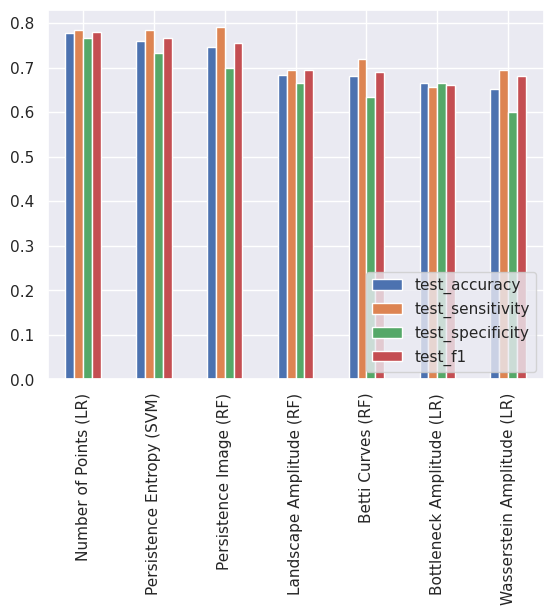

In [34]:
grouped = featurizer_models_patients.groupby("Featurizer")
max_index = grouped["test_accuracy"].idxmax()
best_models = featurizer_models_patients.loc[max_index].sort_values("test_accuracy", ascending=False)
best_models.index = best_models.reset_index().Featurizer + " (" + best_models.reset_index().model + ")"

best_models_std = featurizer_models_std_patients.loc[max_index]
best_models_std.index = best_models_std.reset_index().Featurizer + " (" + best_models_std.reset_index().model + ")"
best_models_std = best_models_std.loc[best_models.index]

best_models.plot.bar()
plt.legend(loc='lower right')

best_models.style.apply(highlight_max).format("{:.2f}")

In [35]:
# Make latex
latex = best_models.applymap(lambda x: f"{x:.2f}") + " $_{\pm " + best_models_std.applymap(lambda x: f"{x:.2f}") + "}$"
# Drop all rows containint "Amplitude"
latex = latex[~latex.index.str.contains("Amplitude")]
print(latex.to_latex(escape=False))

\begin{tabular}{lllll}
\toprule
{} &       test_accuracy &    test_sensitivity &    test_specificity &             test_f1 \\
\midrule
Number of Points (LR)     &  0.78 $_{\pm 0.09}$ &  0.79 $_{\pm 0.17}$ &  0.77 $_{\pm 0.09}$ &  0.78 $_{\pm 0.10}$ \\
Persistence Entropy (SVM) &  0.76 $_{\pm 0.08}$ &  0.79 $_{\pm 0.17}$ &  0.73 $_{\pm 0.09}$ &  0.77 $_{\pm 0.10}$ \\
Persistence Image (RF)    &  0.75 $_{\pm 0.10}$ &  0.79 $_{\pm 0.21}$ &  0.70 $_{\pm 0.22}$ &  0.76 $_{\pm 0.12}$ \\
Betti Curves (RF)         &  0.68 $_{\pm 0.09}$ &  0.72 $_{\pm 0.21}$ &  0.63 $_{\pm 0.07}$ &  0.69 $_{\pm 0.12}$ \\
\bottomrule
\end{tabular}



# Severity Scores

In [19]:
sev_scores = get_manual_severity_scores()
sev_scores = sev_scores[["Severity Score", "video_name"]]
sev_scores["Severity Score"] = sev_scores["Severity Score"].astype(int)
df = pd.merge(df, sev_scores, on="video_name")

Number of discarded rows: 8


/tmp/ipykernel_18712/1783145124.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sev_scores["Severity Score"] = sev_scores["Severity Score"].astype(int)


In [20]:
import importlib
import ml_pipeline
importlib.reload(ml_pipeline)
from ml_pipeline import ModelEvaluation


Multi_Classifier = ModelEvaluation(mode="classification_multi_label")

In [21]:
featurizer_models = pd.DataFrame()
featurizer_models_all = pd.DataFrame()
featurizer_models_std = pd.DataFrame()
for name, featurizer in featurizers.items():
    print(f"Training model for {name}...")
    X = np.stack(df[name].values)
    y = df["Severity Score"].values
    groups = df["Patient ID"].values
    
    scores, scores_mean, scores_std = Multi_Classifier.train_models(X, y, groups=groups, plot=False, return_std = True)
    scores = pd.concat([scores], keys=[name], names=['Featurizer'])
    scores_mean = pd.concat([scores_mean], keys=[name], names=['Featurizer'])
    scores_std = pd.concat([scores_std], keys=[name], names=['Featurizer'])
    
    featurizer_models_all = pd.concat([featurizer_models_all, scores])
    featurizer_models = pd.concat([featurizer_models, scores_mean])
    featurizer_models_std = pd.concat([featurizer_models_std, scores_std])

featurizer_models.groupby("Featurizer").mean().sort_values(by=["test_f1"], ascending=False).style.apply(highlight_max).format("{:.2f}")

Training model for Persistence Entropy...


/scratch_net/gnarf/mrichte/conda_envs/DL4LUS/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1327: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/scratch_net/gnarf/mrichte/conda_envs/DL4LUS/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1327: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/scratch_net/gnarf/mrichte/conda_envs/DL4LUS/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1327: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/scr

Training model for Number of Points...
Training model for Wasserstein Amplitude...
Training model for Bottleneck Amplitude...
Training model for Landscape Amplitude...


/scratch_net/gnarf/mrichte/conda_envs/DL4LUS/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1327: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/scratch_net/gnarf/mrichte/conda_envs/DL4LUS/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1327: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/scratch_net/gnarf/mrichte/conda_envs/DL4LUS/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1327: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/scr

Training model for Betti Curves...


/scratch_net/gnarf/mrichte/conda_envs/DL4LUS/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:444: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/scratch_net/gnarf/mrichte/conda_envs/DL4LUS/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:444: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/st

Training model for Persistence Image...


/scratch_net/gnarf/mrichte/conda_envs/DL4LUS/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:444: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/scratch_net/gnarf/mrichte/conda_envs/DL4LUS/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:444: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/st

,test_accuracy,test_f1,test_recall,test_precision
Featurizer,,,,
Wasserstein Amplitude,0.36,0.35,0.36,0.36
Number of Points,0.37,0.35,0.37,0.38
Bottleneck Amplitude,0.36,0.34,0.36,0.38
Betti Curves,0.33,0.32,0.33,0.34
Landscape Amplitude,0.35,0.32,0.35,0.32
Persistence Image,0.31,0.30,0.31,0.32
Persistence Entropy,0.32,0.30,0.32,0.30


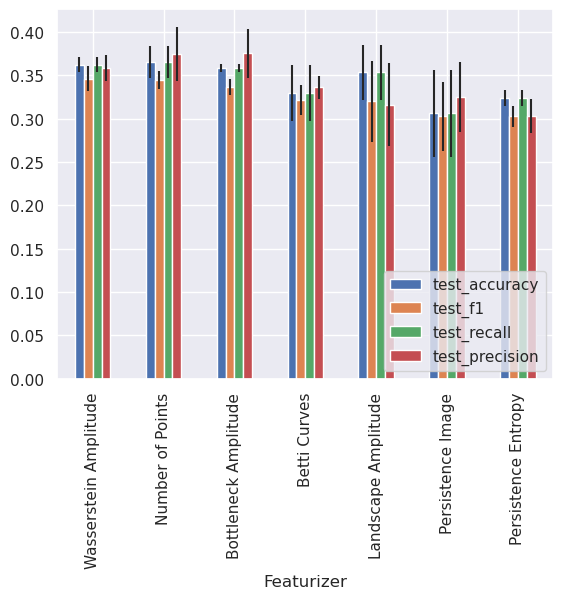

In [22]:
featurizer_models.groupby("Featurizer").mean().sort_values(by=["test_f1"], ascending=False).plot.bar(yerr=featurizer_models.groupby("Featurizer").std())
plt.legend(loc='lower right')

,test_accuracy,test_f1,test_recall,test_precision
Landscape Amplitude (RF),0.39,0.37,0.39,0.37
Number of Points (LR),0.38,0.36,0.38,0.39
Wasserstein Amplitude (LR),0.37,0.35,0.37,0.37
Bottleneck Amplitude (RF),0.36,0.35,0.36,0.36
Persistence Image (RF),0.36,0.35,0.36,0.37
Betti Curves (RF),0.37,0.34,0.37,0.35
Persistence Entropy (LR),0.33,0.31,0.33,0.31


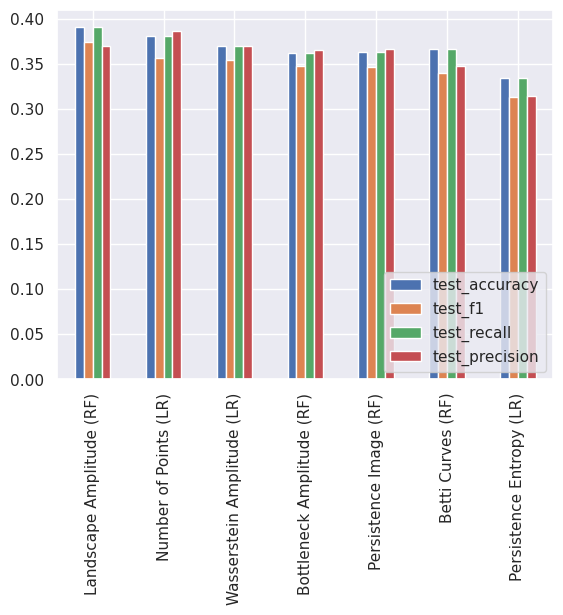

In [25]:
grouped = featurizer_models.groupby("Featurizer")
max_index = grouped["test_accuracy"].idxmax()
best_models = featurizer_models.loc[max_index].sort_values("test_f1", ascending=False)
best_models.index = best_models.reset_index().Featurizer + " (" + best_models.reset_index().model + ")"

best_models_std = featurizer_models_std.loc[max_index]
best_models_std.index = best_models_std.reset_index().Featurizer + " (" + best_models_std.reset_index().model + ")"
best_models_std = best_models_std.loc[best_models.index]

best_models.plot.bar()
plt.legend(loc='lower right')

best_models.style.apply(highlight_max).format("{:.2f}")

In [26]:
# Make latex
latex = best_models.applymap(lambda x: f"{x:.2f}") + " $_{\pm " + best_models_std.applymap(lambda x: f"{x:.2f}") + "}$"
# Drop accuracy
latex = latex.drop("test_accuracy", axis=1)
# Drop all rows containing "Amplitude"
latex = latex[~latex.index.str.contains("Amplitude")]
print(latex.to_latex(escape=False))

\begin{tabular}{llll}
\toprule
{} &             test_f1 &         test_recall &      test_precision \\
\midrule
Number of Points (LR)    &  0.36 $_{\pm 0.07}$ &  0.38 $_{\pm 0.07}$ &  0.39 $_{\pm 0.07}$ \\
Persistence Image (RF)   &  0.35 $_{\pm 0.08}$ &  0.36 $_{\pm 0.06}$ &  0.37 $_{\pm 0.08}$ \\
Betti Curves (RF)        &  0.34 $_{\pm 0.08}$ &  0.37 $_{\pm 0.07}$ &  0.35 $_{\pm 0.08}$ \\
Persistence Entropy (LR) &  0.31 $_{\pm 0.08}$ &  0.33 $_{\pm 0.06}$ &  0.31 $_{\pm 0.09}$ \\
\bottomrule
\end{tabular}

